# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [16]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# Set the random seed to reproduce same results
torch.manual_seed(13) 
np.random.seed(13)

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [51]:
# Transform and Dataloader parameters
batch_size = 60
rotation_angle = 25
valid_portion = 0.25

# Define transforms
traintransform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(degrees=rotation_angle),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ])
testtransform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])


# Define training and validation data
trainset= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=traintransform)
validset= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=testtransform)
#split validation set
indicies = np.arange(len(trainset))
np.random.shuffle(indicies)
pos_split= int(np.floor((1-valid_portion) * len(trainset)))
train_ind, valid_ind = indicies[:pos_split], indicies[pos_split:]
train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(valid_ind)
#load split data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False,
                                          sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False,
                                          sampler=valid_sampler, num_workers=2)
N_trainloader = len(trainloader)
N_validloader = len(validloader)

# Define test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=testtransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
N_testloader = len(testloader)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [34]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy()/2 +0.5 #unnormalize
        plt.imshow(image.T)
        plt.show()

deer


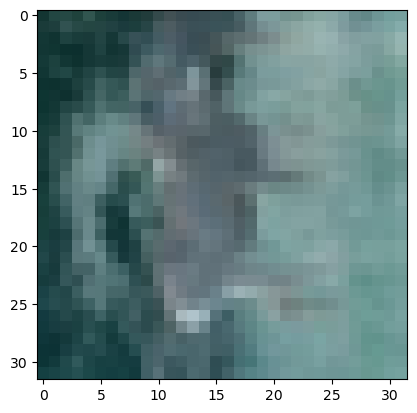

truck


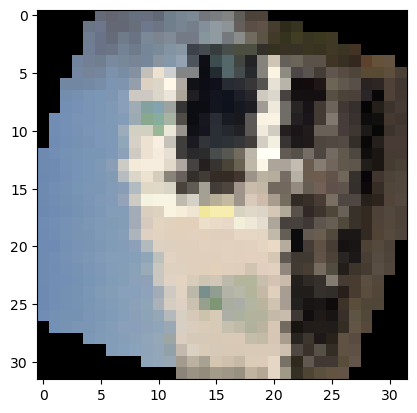

deer


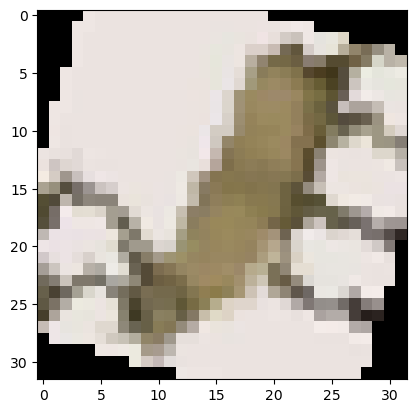

deer


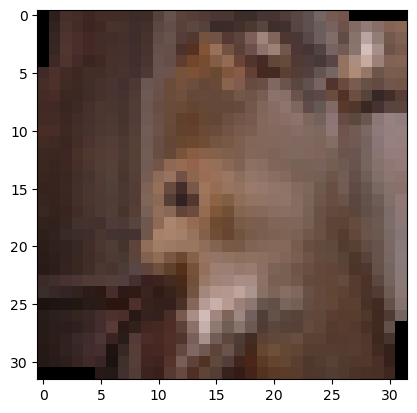

ship


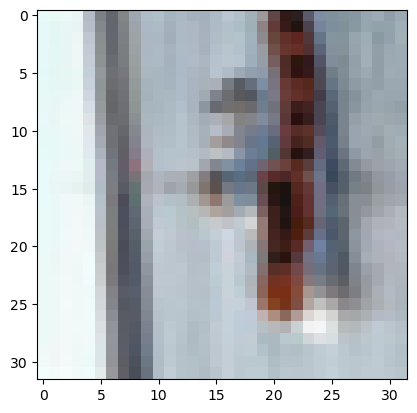

In [35]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [58]:
model = nn.Sequential(nn.Conv2d(3, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.Flatten(),
                      nn.Linear(1024, 128), nn.ReLU(),nn.Dropout(0.2),
                      nn.Linear(128, 64), nn.ReLU(),
                      nn.Linear(64, 10), 
                      nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [59]:
## Define a loss function
criterion =  nn.NLLLoss()

## Define an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [60]:
# Initialize
epochs = 30
train_losses, valid_losses, valid_accuracies = [], [],[]

# Train model
for e in range(epochs):
    train_loss = 0
    for n, data in enumerate(trainloader):
        if n==0: print(f'Epoch: {e+1}/{epochs}:')
        
        # get inputs
        images, labels = data
        
        # zero the parameter gradients    
        optimizer.zero_grad()
        
        # forward + backward + optimize
        log_ps= model.forward(images)
        loss  = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    else: valid_loss, valid_acc = 0,0 
        
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images, labels in validloader:
            log_ps = model.forward(images)
            valid_loss += criterion(log_ps, labels)
            
            # calculate accuracy
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_acc += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()

    # Average out the statistics
    train_loss = train_loss/N_trainloader
    valid_loss = valid_loss/N_validloader
    valid_acc  = valid_acc/N_validloader

    # Print statistics
    print(f'\tTraining Loss:   {train_loss:.3f}\n',
          f'\tValidation Loss: {valid_loss:.3f},\tValidation Accuracy: {valid_acc*100:.1f}%')
    # Save statistics
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

        
print('Finished Training')



Epoch: 1/30:
	Training Loss:   2.238
 	Validation Loss: 1.999,	Validation Accuracy: 27.2%
Epoch: 2/30:
	Training Loss:   1.792
 	Validation Loss: 1.619,	Validation Accuracy: 40.9%
Epoch: 3/30:
	Training Loss:   1.553
 	Validation Loss: 1.459,	Validation Accuracy: 46.2%
Epoch: 4/30:
	Training Loss:   1.424
 	Validation Loss: 1.300,	Validation Accuracy: 52.7%
Epoch: 5/30:
	Training Loss:   1.333
 	Validation Loss: 1.222,	Validation Accuracy: 55.8%
Epoch: 6/30:
	Training Loss:   1.252
 	Validation Loss: 1.142,	Validation Accuracy: 58.7%
Epoch: 7/30:
	Training Loss:   1.186
 	Validation Loss: 1.099,	Validation Accuracy: 60.7%
Epoch: 8/30:
	Training Loss:   1.135
 	Validation Loss: 1.041,	Validation Accuracy: 62.6%
Epoch: 9/30:
	Training Loss:   1.087
 	Validation Loss: 0.986,	Validation Accuracy: 65.0%
Epoch: 10/30:
	Training Loss:   1.047
 	Validation Loss: 0.949,	Validation Accuracy: 66.1%
Epoch: 11/30:
	Training Loss:   1.013
 	Validation Loss: 0.927,	Validation Accuracy: 67.5%
Epoch: 1

Plot the training loss (and validation loss/accuracy, if recorded).

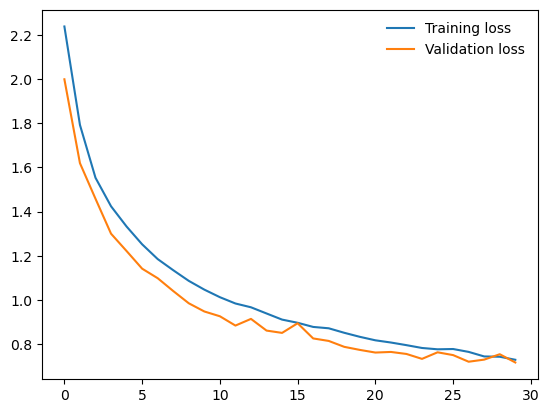

In [67]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [65]:
test_model = model
test_loss, test_acc = 0, 0

test_model.eval()
# Turn off gradients for testing, saves memory and computations
with torch.no_grad():
    for images, labels in testloader:
        log_ps = model.forward(images)
        test_loss += criterion(log_ps, labels)
            
        # calculate accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
    test_acc  = test_acc/N_testloader
    print(f'\tAverage Testing Loss: {valid_loss:.3f},\tTest Accuracy: {valid_acc*100:.1f}%')

	Average Testing Loss: 0.718,	Test Accuracy: 75.4%


## Saving your model
Using `torch.save`, save your model for future loading.

In [66]:
torch.save(model.state_dict(), './final_model')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

>  I built a relatively simple neural network model that classified CIFAR-10 images with 75% accuracy of the testing dataset, which ran on a laptop CPU. Based on the observed convergence of training and validation errors, I believe that further epoch iterations, as well as further parameter fine-tuning, could increase the accuracy. Thus, buying a NN algorithm that only achives 70% accuracy is not recommend when a better model can be built.